## Predicting Students Academic Success ##

https://www.kaggle.com/datasets/naveenkumar20bps1137/predict-students-dropout-and-academic-success/data

This dataset is supported by program SATDAP - Capacitação da Administração Pública under grant POCI-05-5762-FSE-000191, Portugal

Checking the Dataset

In [59]:
#Import Center
import pandas as pd
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

In [60]:
#Import the Database 
df = pd.read_csv("dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Nacionality                                     4424 non-null   int64  
 7   Mother's qualification                          4424 non-null   int64  
 8   Father's qualification                          4424 non-null   int64  
 9   Mother's occupation                      

In [61]:
#Checking For Nulls
df.isnull().sum() #No Nulls

#Checking for duplicates 
df.duplicated().sum() #No Duplicates

np.int64(0)

In [62]:
#Fix Spelling Error
df.rename(columns={'Nacionality': 'Nationality'}, inplace=True)

In [63]:
#Checking the Shape
df.shape

(4424, 35)

Checking the distribution of the Target variable!

In [64]:
df['Target'].value_counts()

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

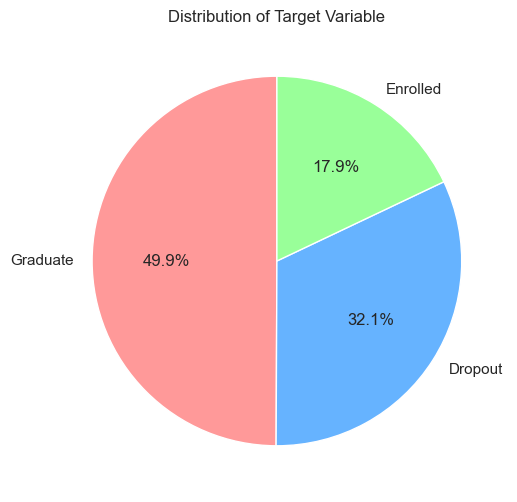

In [65]:
target_counts = df['Target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title('Distribution of Target Variable')
plt.show()

Since Enrolled means they are still in school, its best to drop that data since we want to focus on the end of the students academic journey!

In [66]:
df = df[df.Target != 'Enrolled']
df.shape

(3630, 35)

We can see the shape has changed from 4424 to 3630

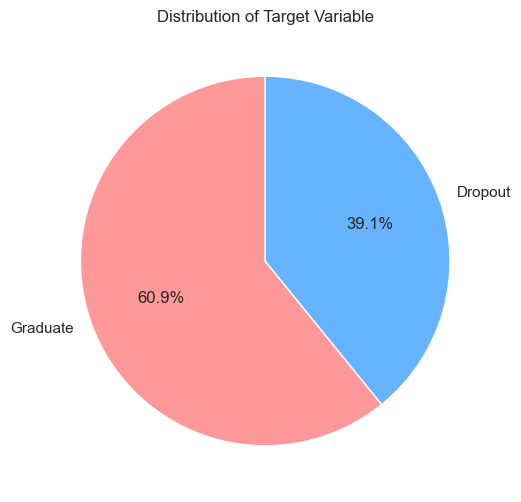

In [67]:
target_counts = df['Target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'], startangle=90)
plt.title('Distribution of Target Variable')
plt.show()

We can see we have about a 60% graduation rate

In [68]:
print(df['Target'].unique())
df.value_counts('Target')

['Dropout' 'Graduate']


Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64

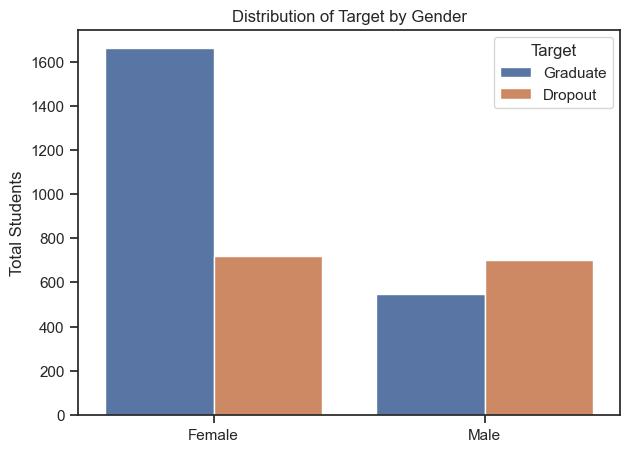

In [69]:
sb.set_style('ticks')
sb.countplot(df, x='Gender', hue='Target')

plt.xticks(ticks=[0,1], labels=['Female', 'Male'])
plt.ylabel('Total Students')
plt.xlabel(None)
plt.title('Distribution of Target by Gender')

plt.show()

In [70]:
ct_gender = pd.crosstab(df['Target'], df['Gender'])
ct_gender = ct_gender.rename(columns={0: 'Female', 1: 'Male'})
ct_gender

Gender,Female,Male
Target,,
Dropout,720,701
Graduate,1661,548


In this dataset we clearly have more data for Women vs Men. Based on this however, it seems men are more likedly to drop out compared to women

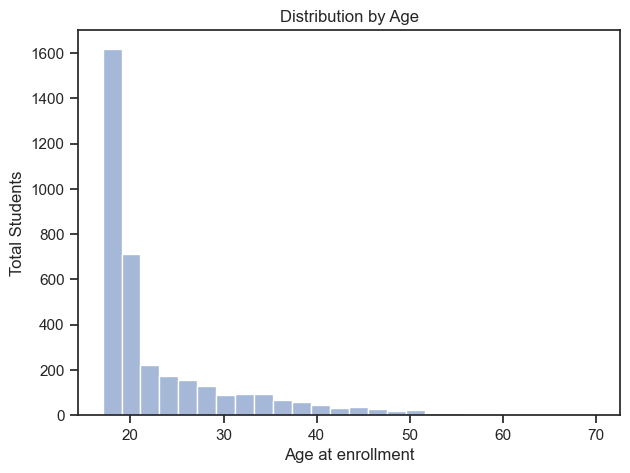

In [71]:
sb.set_style('ticks')
sb.histplot(df, x='Age at enrollment', alpha=0.5, binwidth=2)

# Customize the labels
plt.title('Distribution by Age')
plt.ylabel('Total Students')

plt.show()

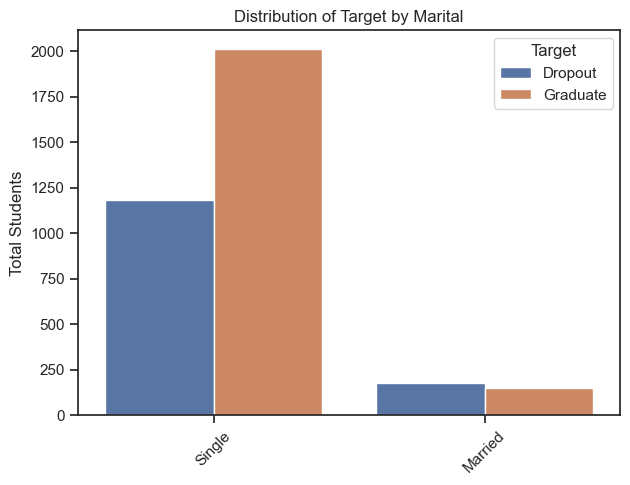

In [72]:
DroppedMartialStatus = df[(df['Marital status'] == 1) | (df['Marital status'] == 2)]
sb.set(rc={'figure.figsize':(7, 5)})
sb.set_style('ticks')
sb.countplot(DroppedMartialStatus, x='Marital status', hue='Target')

plt.xticks(ticks=[0, 1], labels=['Single', 'Married'], rotation=45)

plt.ylabel('Total Students')
plt.xlabel(None)
plt.title('Distribution of Target by Marital')

plt.show()

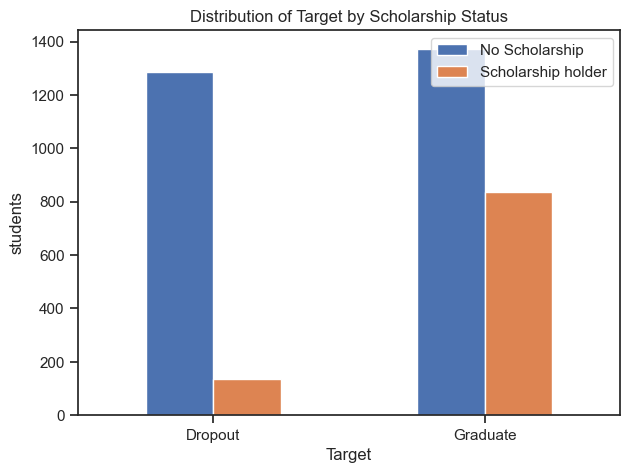

In [73]:
pd.crosstab(df.Target, df['Scholarship holder']).plot(kind='bar')
plt.title("Distribution of Target by Scholarship Status")
plt.ylabel("students")
plt.legend(["No Scholarship", "Scholarship holder"])
plt.xticks(rotation=0);

Showing Distribution by Classes

In [74]:
#Since the data is set by int we need to map each value to its actual name 
course_names =                                  {1: 'Biofuel Production Technologies',
                                                2: 'Animation and Multimedia Design',
                                                3: 'Social Service (evening attendance)',
                                                4: 'Agronomy',
                                                5: 'Communication Design',
                                                6: 'Veterinary Nursing',
                                                7: 'Informatics Engineering',
                                                8: 'Equinculture',
                                                9: 'Management',
                                                10: 'Social Service',
                                                11: 'Tourism',
                                                12: 'Nursing',
                                                13: 'Oral Hygiene',
                                                14: 'Advertising and Marketing Management',
                                                15: 'Journalism and Communication',
                                                16: 'Basic Education',
                                                17: 'Management (evening attendance)'}

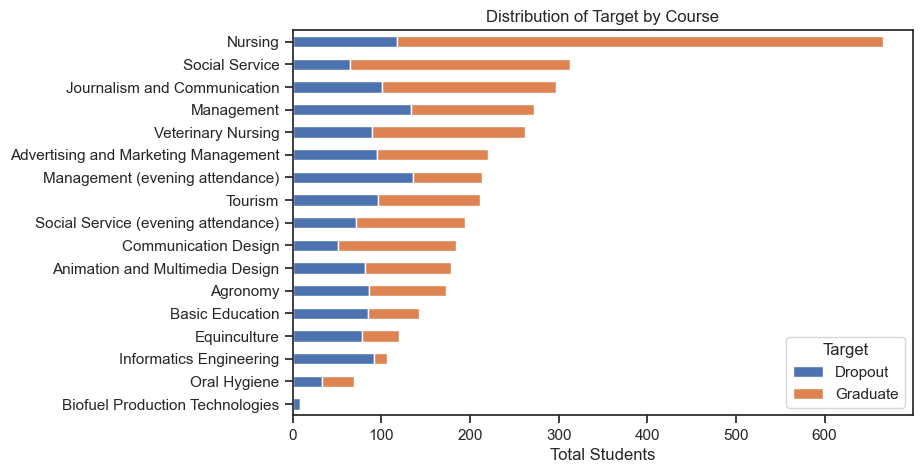

In [75]:
# Group by Course and Target
student_courses = df.groupby(['Course', 'Target']).size().reset_index().pivot(columns='Target', index='Course', values=0)
student_courses = student_courses.rename(index=course_names)

# Sum the total number of students for each course and sort for the plot
student_courses['Total'] = student_courses.sum(axis=1)
student_courses_sorted = student_courses.sort_values(by='Total', ascending=True)

# Remove the 'Total' column
student_courses_sorted.drop(columns='Total', inplace=True)

sb.set(rc={'figure.figsize':(8, 5)})
sb.set_style('ticks')
course_plot = student_courses_sorted.plot(kind='barh', stacked=True)

plt.title('Distribution of Target by Course')
plt.legend(labels=["Dropout", "Graduate"], title='Target')
plt.xlabel('Total Students')
plt.ylabel(None)

plt.show()

In this data we have mainly nursing students!

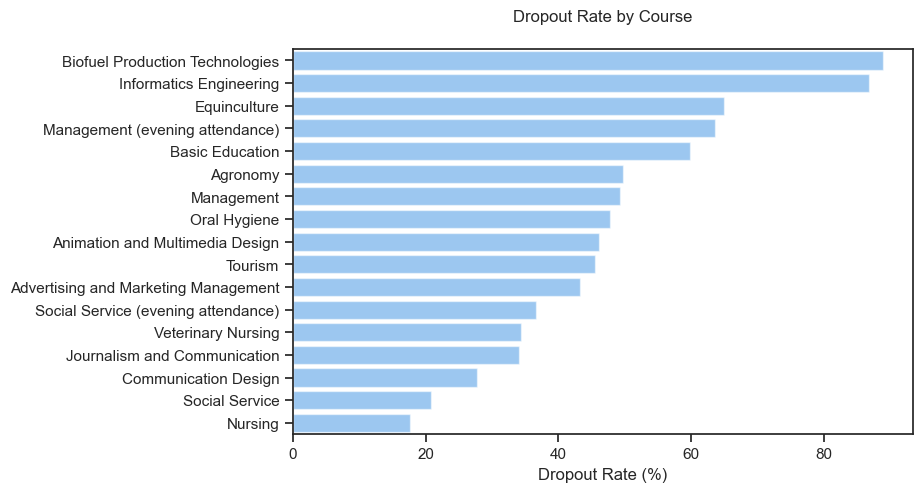

In [76]:
df2 = df.copy()
df2['Course'] = df2['Course'].map(course_names)

# Calculate dropout percentages and sort in descending order
dropout_counts = df2.groupby('Course')['Target'].apply(lambda x: (x == 'Dropout').sum())
total_counts = df2['Course'].value_counts()

dropout_percentages = (dropout_counts / total_counts) * 100
dropout_percentages_sorted = dropout_percentages.sort_values(ascending=False)

# Convert to Data Frame
dropout_rate_df = pd.DataFrame({
    'Course': dropout_percentages_sorted.index,
    'Dropout Rate': dropout_percentages_sorted.values
})

# Visualize in a horizontal bar plot
sb.set_style('ticks')
sb.barplot(dropout_rate_df, x='Dropout Rate', y='Course', 
            color='dodgerblue', alpha=0.5)

# Style the plot
plt.title('Dropout Rate by Course', pad=20)
plt.xlabel('Dropout Rate (%)')
plt.ylabel(None)

plt.show()

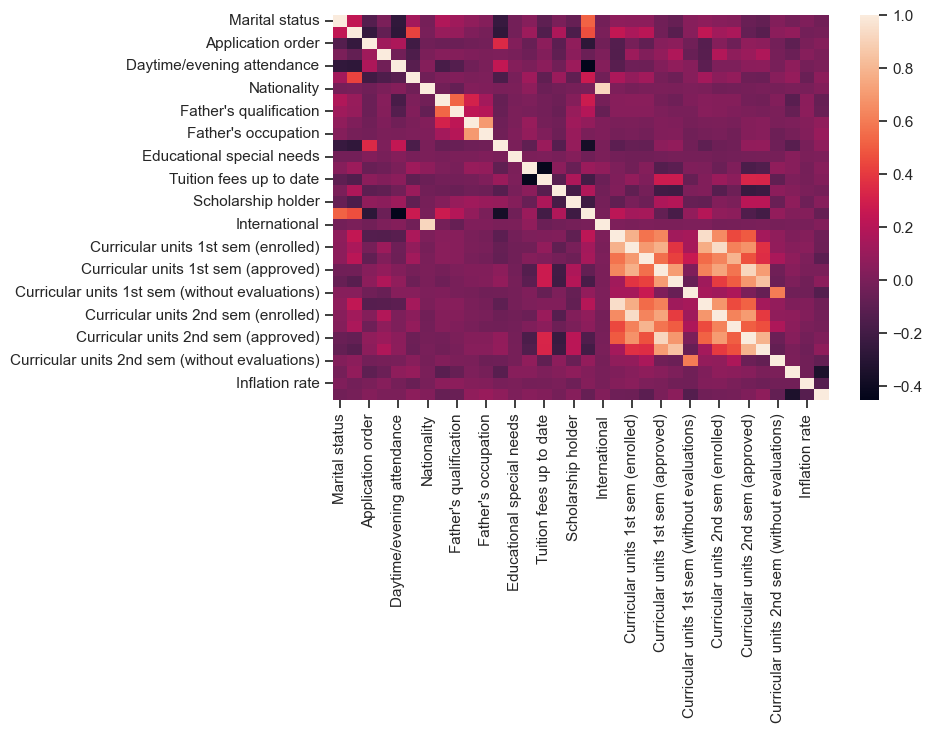

In [77]:
dataplot = sb.heatmap(df.corr(numeric_only=True))
plt.show()

We can zoom in on where the heat map shows the most correlation

In [78]:
academic_path = df[['Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)',
       'Target']]

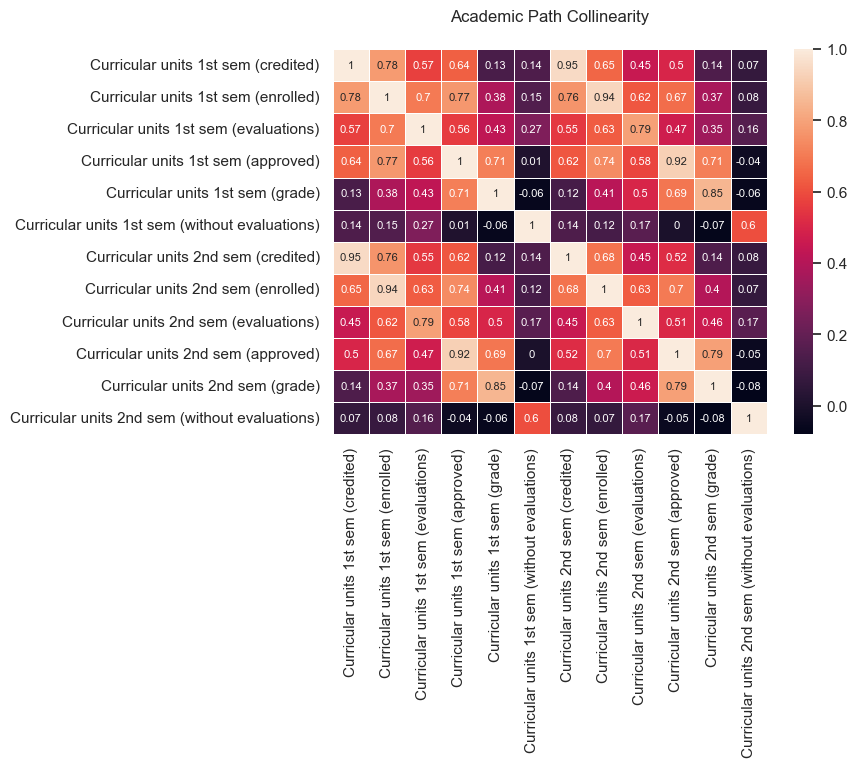

In [79]:
sb.set(rc={"figure.figsize": (7, 5)})
sb.heatmap(academic_path.corr(numeric_only=True).round(2), linewidths=0.5,
            annot=True, annot_kws={"size": 8})
# Customize the labels
plt.title('Academic Path Collinearity', pad=20)

plt.show()

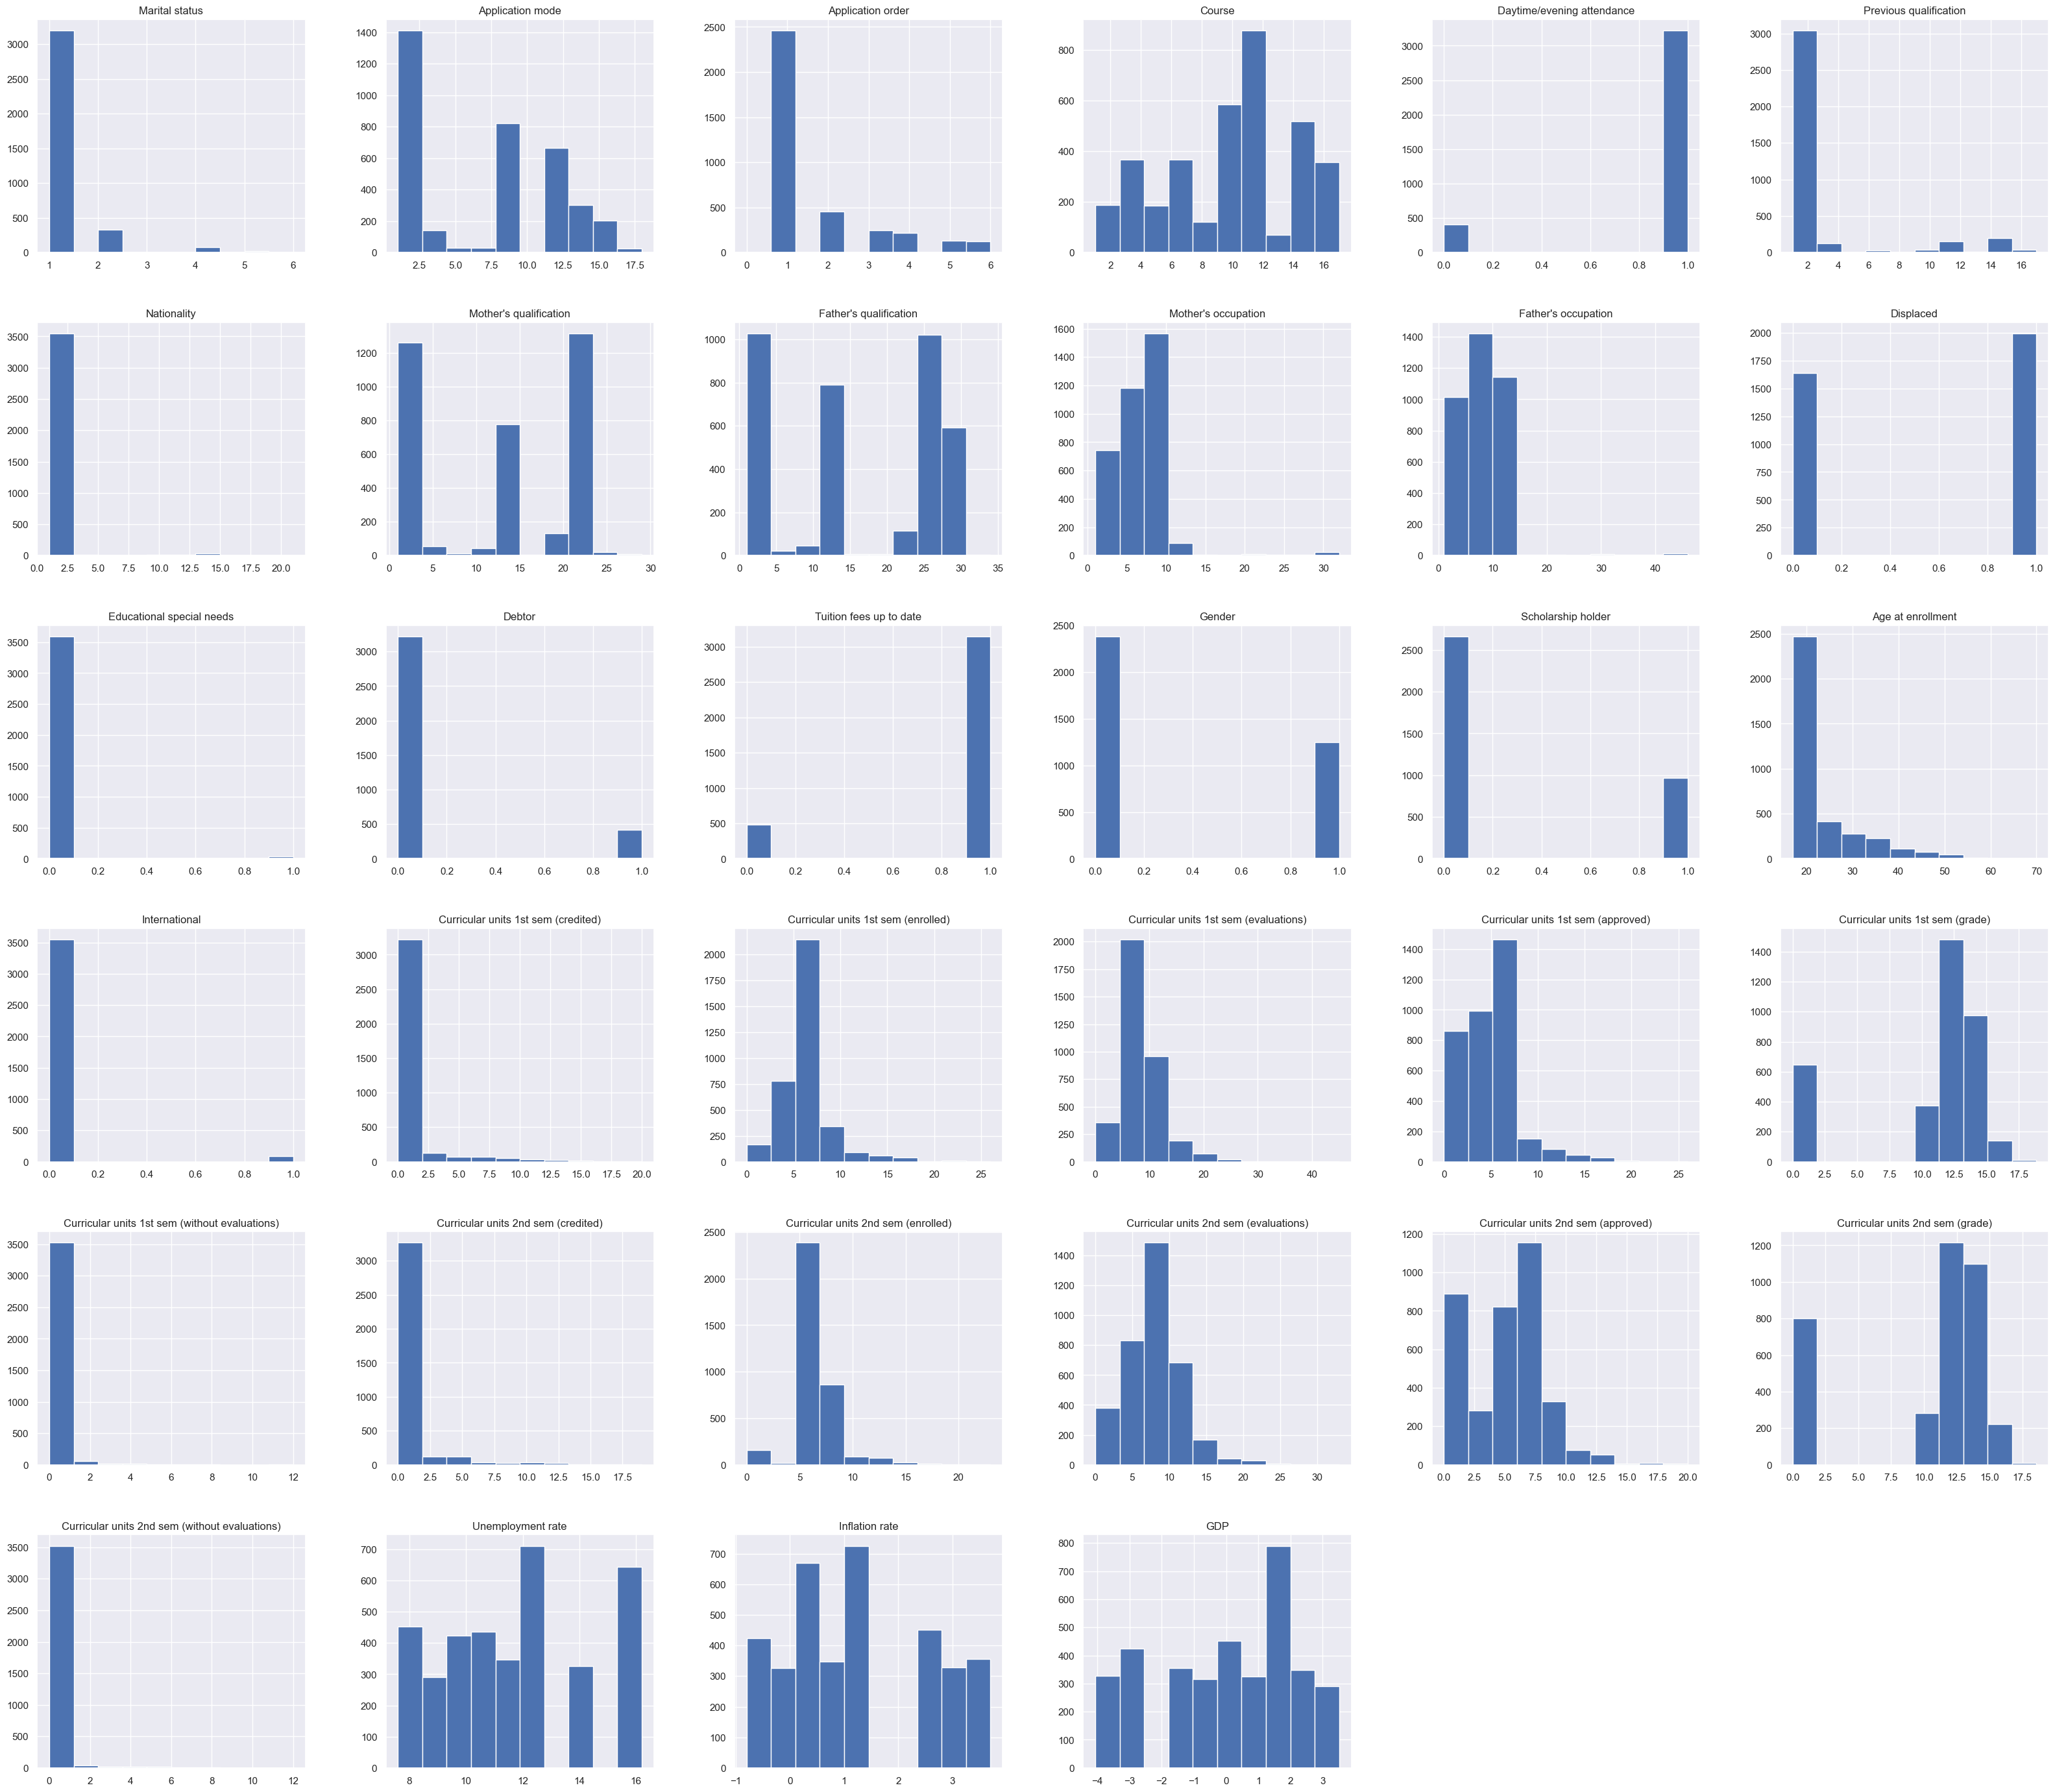

In [80]:
sb.set_theme(style = 'darkgrid')
df.hist(bins=10, figsize=(40, 35), grid=True, legend=None);

# MACHINE LEARNING APPROACH

In [81]:
#Mapping the target values to Numbers 
#1 will be graduated, 0 will be dropped out
df['Target'] = df['Target'].map({'Graduate':1, 'Dropout':0})

In [82]:
#Checking to make sure it worked
print(df['Target'].unique())
df.value_counts('Target')

[0 1]


Target
1    2209
0    1421
Name: count, dtype: int64

In [83]:
#Assigned x and y
x = df.drop(columns=['Target'],axis=1)
y= df['Target']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=10)

Checking to see which model to go with

In [85]:
#Testing Mutiple Models 
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest' : RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
}

def fit_and_score(models, x_train, x_test, y_train, y_test):
    np.random.seed(42)
    model_score = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        model_score[name] = model.score(x_test, y_test)
    return model_score

model_scores = fit_and_score(models, X_train, X_test, y_train, y_test);

C:\Users\19ast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [86]:
model_scores

{'Logistic Regression': 0.9352617079889807,
 'Random Forest': 0.9297520661157025,
 'Decision Tree': 0.871900826446281}

Based on this we can see Logistic Regression is what to go with

In [87]:
log = LogisticRegression()
log.fit(X_train,y_train)
log.score(X_test, y_test)

C:\Users\19ast\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9352617079889807

In [88]:
#print Accuracy Scores 
print('Training Accuracy: ', log.score(X_train, y_train))
print('Testing Accuracy: ',log.score(X_test, y_test))

Training Accuracy:  0.912534435261708
Testing Accuracy:  0.9352617079889807


In [89]:
y_pred = log.predict(X_test)

print("Classification Report")
print(classification_report(y_test, y_pred))
#1 is graduated, 0 is dropped out

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       245
           1       0.93      0.98      0.95       481

    accuracy                           0.94       726
   macro avg       0.94      0.92      0.93       726
weighted avg       0.94      0.94      0.93       726



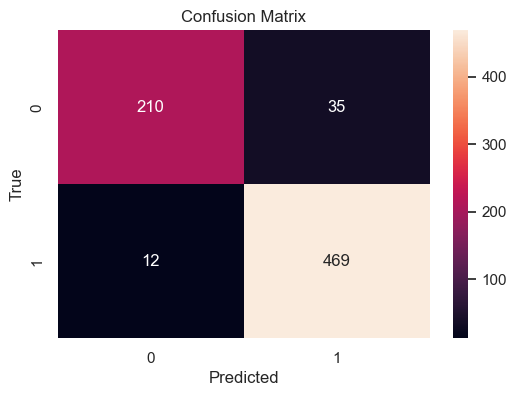

In [90]:
con_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6,4))
sb.heatmap(con_matrix, annot=True,fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [91]:
print('Accuracy For Testing Data: %3f' % accuracy_score(y_test, y_pred))
print('Recall For Testing Data: %.3f' % recall_score(y_test, y_pred))
print('Precision For Testing Data: %.3f' % precision_score(y_test,y_pred))
print('F1 For Testing Data: %.3f' % f1_score(y_test, y_pred))

Accuracy For Testing Data: 0.935262
Recall For Testing Data: 0.975
Precision For Testing Data: 0.931
F1 For Testing Data: 0.952


# Feature Importance

In [92]:
feat_importance = log.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': x.columns,
    'Coefficient': feat_importance
})

In [93]:
#This allows us to see what each Index is 
feature_importance

,Feature,Coefficient
0,Marital status,0.144749
1,Application mode,-0.023190
2,Application order,-0.032775
3,Course,-0.104669
4,Daytime/evening attendance,-0.335171
5,Previous qualification,0.019825
6,Nationality,0.031560
7,Mother's qualification,-0.017660
8,Father's qualification,0.011814
9,Mother's occupation,0.054602


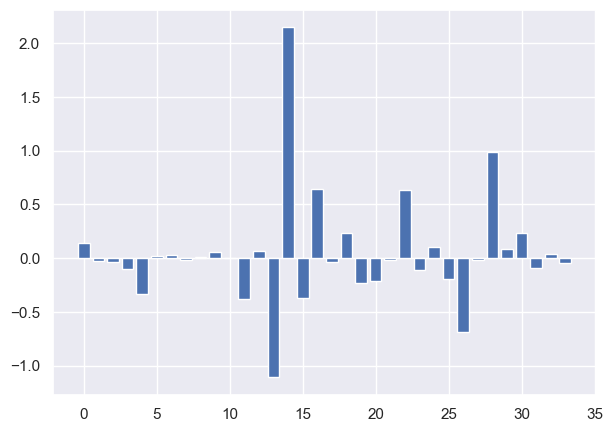

In [94]:
plt.bar([
    x for x in range(len(feat_importance))], feat_importance)
plt.show()

# Permutation Importance

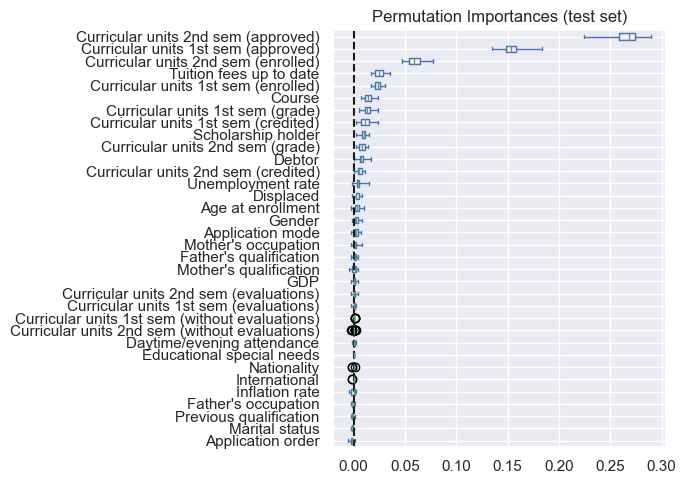

In [95]:
perm_importance = permutation_importance(log, X_test,y_test,n_repeats=30, random_state=10)

sorted_importances_idx = perm_importance.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance.importances[sorted_importances_idx].T,
    columns=x.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis = 10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color = "k", linestyle = "--")
ax.figure.tight_layout()
